In [1]:
import json
import pandas as pd
import numpy as np
import datetime
import tqdm
import pickle
import time
import requests
from bs4 import BeautifulSoup
from lxml import html
import operator
import math

%matplotlib inline
import seaborn as sns

pd.set_option('max_columns', 100)
ya_token = ''

In [2]:
def measure(lat1, lon1, lat2, lon2):
    
    '''
    
    Функция для рассчета расстояния между двумя точками на карте
    
    '''
    
    R = 6378.137
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * \
        math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon / 2)
        
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d * 1000

# Имортируем файл с данными, выгруженными с t-s.by и преобразовываем его в Pandas DataFrame:


In [3]:
with open('result.json', encoding='utf-8') as f: 
    data = json.load(f)
    
df = pd.io.json.json_normalize(data)
df.index = df[u'Код объекта'].apply(pd.to_numeric)
del df[u'Код объекта']
df.head(1)

,Адрес,Балкон,Ближайшее метро,Год капитального ремонта,Год постройки,Город,Комнаты,Материал стен,Микрорайон,Описание,Площади,Полы,Район,Санузел,Телефон,Тип дома,Условия продажи,Цена,Этаж / Этажность
Код объекта,,,,,,,,,,,,,,,,,,,
818272,"Ташкентская ул., 24 корпус 3",лоджия застекленная,NaN,0,1977,Минск,3,блок-комнаты,Чижовка,Комната в трехкомнатной квартире в микрорайоне...,71.4 / 13.95 / 9.16,линолеум,Заводской район,раздельный,есть,стандартные,чистая продажа,15 500 у. е.,2/9


# Обогатим lat & long

In [4]:
for index, row in tqdm.tqdm(df.iterrows(), total = df.shape[0]):
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&apikey=%s&geocode=%s' % (ya_token, row['Город'] + ', ' + row['Адрес']))
    r.enconding = 'cp1251'
    j = json.loads(r.text)
    ar = j.get('response').get('GeoObjectCollection').get('featureMember')
    if len(ar) != 0:
        p_lat, p_long = ar[0].get('GeoObject').get('Point').get('pos').split(' ')
    df.loc[index, 'lat'] = p_lat
    df.loc[index, 'long'] = p_long
df.head(1)

100%|████████████████████████████████████████████████████████████████████████████████| 410/410 [01:51<00:00,  3.68it/s]


,Адрес,Балкон,Ближайшее метро,Год капитального ремонта,Год постройки,Город,Комнаты,Материал стен,Микрорайон,Описание,Площади,Полы,Район,Санузел,Телефон,Тип дома,Условия продажи,Цена,Этаж / Этажность,lat,long
Код объекта,,,,,,,,,,,,,,,,,,,,,
818272,"Ташкентская ул., 24 корпус 3",лоджия застекленная,NaN,0,1977,Минск,3,блок-комнаты,Чижовка,Комната в трехкомнатной квартире в микрорайоне...,71.4 / 13.95 / 9.16,линолеум,Заводской район,раздельный,есть,стандартные,чистая продажа,15 500 у. е.,2/9,27.634523,53.84655


# Обогатим информацией о расстоянии до POI от квартиры

In [5]:
for index, row in df.iterrows():
    lat = float(row.long)
    long = float(row.lat)
            
    # река / озеро / ручей / водохранилище 
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&geocode=' + ','.join([str(lat), str(long)]) + '&kind=hydro' + '&spn=0.6,0.6' + '&apikey=%s' % ya_token)
    r.enconding = 'cp1251'
    j = json.loads(r.text)
    ar = j.get('response').get('GeoObjectCollection').get('featureMember')
    if len(ar) != 0 and ar[0] is not None:
        p_lat, p_long = ar[0].get('GeoObject').get('Point').get('pos').split(' ')
        p_long, p_lat = float(p_long), float(p_lat)
        df.loc[index, 'distance_hydro'] = measure(lat, long, p_lat, p_long)
    
    # ж.д. станция
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&geocode=' + ','.join([str(lat), str(long)]) + '&kind=railway' + '&spn=0.6,0.6' + '&apikey=%s' % ya_token)
    r.enconding = 'cp1251'
    j = json.loads(r.text)
    ar = j.get('response').get('GeoObjectCollection').get('featureMember')
    if len(ar) != 0 and ar[0] is not None:
        p_lat, p_long = ar[0].get('GeoObject').get('Point').get('pos').split(' ')
        p_long, p_lat = float(p_long), float(p_lat)
        df.loc[index, 'distance_railway'] = measure(lat, long, p_lat, p_long)
    
    # линия метро / шоссе / ж.д. линия
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&geocode=' + ','.join([str(lat), str(long)]) + '&kind=route' + '&spn=0.6,0.6' + '&apikey=%s' % ya_token)
    r.enconding = 'cp1251'
    j = json.loads(r.text)
    ar = j.get('response').get('GeoObjectCollection').get('featureMember')
    if len(ar) != 0 and ar[0] is not None:
        p_lat, p_long = ar[0].get('GeoObject').get('Point').get('pos').split(' ')
        p_long, p_lat = float(p_long), float(p_lat)
        df.loc[index, 'distance_route'] = measure(lat, long, p_lat, p_long)
    
    # лес / парк / сад 
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&geocode=' + ','.join([str(lat), str(long)]) + '&kind=vegetation' + '&spn=0.6,0.6' + '&apikey=%s' % ya_token)
    r.enconding = 'cp1251'
    j = json.loads(r.text)
    ar = j.get('response').get('GeoObjectCollection').get('featureMember')
    if len(ar) != 0 and ar[0] is not None:
        p_lat, p_long = ar[0].get('GeoObject').get('Point').get('pos').split(' ')
        p_long, p_lat = float(p_long), float(p_lat)
        df.loc[index, 'distance_vegetation'] = measure(lat, long, p_lat, p_long)
    
    # аэропорт
    r = requests.get('https://geocode-maps.yandex.ru/1.x/?format=json&geocode=' + ','.join([str(lat), str(long)]) + '&kind=airport' + '&spn=0.6,0.6' + '&apikey=%s' % ya_token)
    r.enconding = 'cp1251'
    j = json.loads(r.text)
    ar = j.get('response').get('GeoObjectCollection').get('featureMember')
    if len(ar) != 0 and ar[0] is not None:
        p_lat, p_long = ar[0].get('GeoObject').get('Point').get('pos').split(' ')
        p_long, p_lat = float(p_long), float(p_lat)
        df.loc[index, 'distance_airport'] = measure(lat, long, p_lat, p_long)

# Убираем пропуски в данных

**Расстояние до POI**

In [6]:
for c in [x for x in df.columns.values if 'distance' in x]:
    df[c].fillna(df[c].max(), inplace = True)

**Балкон**

In [7]:
df[u'Балкон'].fillna(u'нет', inplace=True)
def common_converter(mapping, param):
    if param in mapping:
        return mapping[param]
    return param

balcony_mapping = {
        u'балкон застекленный':u'балкон',
        u'лоджия застекленная':u'лоджия',
        u'лоджия застекленная + вагонка':u'лоджия',
        u'балкон застекленный + вагонка':u'балкон',
        u'2 балкона застекленные':u'2 балкона',
        u'2 лоджии застекленные':u'2 лоджии',
        u'3лз':u'3 лоджии',
        u'3л':u'3 лоджии'        
    }

df[u'Балкон'] = df[u'Балкон'].map(lambda x: common_converter(balcony_mapping, x))

**Метро**

In [8]:
df[u'Ближайшее метро'].fillna(u'нет', inplace=True)

**Год постройки и Год капитального ремонта**

In [9]:
df[u'Год постройки'] = df[u'Год постройки'].apply(pd.to_numeric)
df[u'Год капитального ремонта'] = df[u'Год капитального ремонта'].apply(pd.to_numeric)

current_year = datetime.datetime.now().year
def years_from_last_repair(row):
    if row[u'Год капитального ремонта'] == 0:
        row[u'Год капитального ремонта'] = row[u'Год постройки']
    return current_year - row[u'Год капитального ремонта']

df[u'Лет дому'] = df[u'Год постройки'].map(lambda x: current_year - x)
df[u'Лет с момента ремонта'] = df.apply(lambda row: years_from_last_repair(row), axis=1)
df[u'Был капремонт'] = df[u'Год капитального ремонта']!=0

df.drop({u'Год постройки', u'Год капитального ремонта'}, axis=1, inplace=True)

**Комнаты**

In [10]:
df = df[df[u'Комнаты'] != '1/2']

df[u'Комнаты'] = df[u'Комнаты'].map(lambda x: x if x.find('/') == -1 else x.split('/')[0])
df[u'Комнаты'] = df[u'Комнаты'].apply(pd.to_numeric)

**Район и микрорайон**

In [11]:
df['Район'].fillna('Не указан', inplace = True)
df[u'Микрорайон'].fillna(u'Не указан', inplace=True)

**Площади**

In [12]:
df[u'Общая площадь'] = df[u'Площади'].map(lambda x: float(x.split(' / ')[0]))
df[u'Жилая площадь'] = df[u'Площади'].map(lambda x: float(x.split(' / ')[1]))
df[u'Площадь кухни'] = df[u'Площади'].map(lambda x: float(x.split(' / ')[2]))
df = df.drop(u'Площади', axis=1)

**Полы**

In [13]:
df[u'Полы'].fillna(u'Не указано', inplace=True)

**Санузел**

In [14]:
df.drop(821155, inplace=True) # на улице
toilet_mapping = {
    u'2 сан.узла':u'раздельный',
    u'3 сан.узла':u'раздельный'
    }

df[u'Санузел'] = df[u'Санузел'].map(lambda x: common_converter(toilet_mapping, x))
df['Санузел'].fillna('нет', inplace = True)

**Телефон**

In [15]:
df[u'Телефон'] = df[u'Телефон'].map(lambda x: common_converter({u'2 телефона':u'есть'}, x))

**Тип дома**

In [16]:
df[u'Тип дома'].fillna(u'не указан', inplace=True)

**Условия продажи**

In [17]:
df[u'Условия продажи'].fillna(u'не указан', inplace=True)
df[u'Условия продажи'] = df[u'Условия продажи'].map(lambda x: common_converter({u'обмен - разъезд':u'обмен'}, x))

**Цена**

In [18]:
df[u'Цена'] = df[u'Цена'].map(lambda x: float(x[:x.find(u' у. е.')].replace(' ','')))

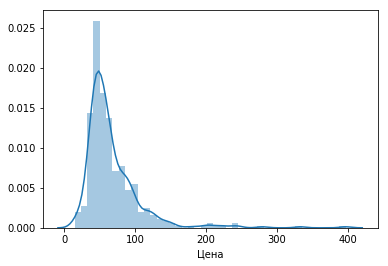

In [19]:
sns.distplot(df[u'Цена']/1000);

**Этаж/этажность**

In [20]:
df.loc[df[u'Этаж / Этажность'].isnull(), u'Этаж / Этажность'] = u'5/9'

In [21]:
df[u'Этаж'] = df[u'Этаж / Этажность'].map(lambda x: int(x.split('/')[0]))
df[u'Этажность'] = df[u'Этаж / Этажность'].map(lambda x: int(x.split('/')[1]))

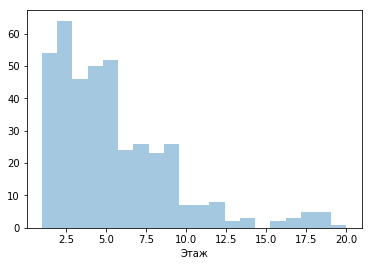

In [22]:
sns.distplot(df[u'Этаж'], kde=False, bins=20);

In [23]:
df[u'Первый этаж'] = df[u'Этаж'].map(lambda x: 1 if x==1 else 0)

In [24]:
df[u'Последний этаж'] = df[u'Этаж / Этажность'].map(lambda x: 1 if x.split('/')[0] == x.split('/')[1] else 0)

In [25]:
df = df.drop(u'Этаж / Этажность', axis=1)

# Выносим таргет

In [28]:
X = df.drop({u'Цена', u'Описание', u'Адрес', 'lat', 'long'}, axis=1)
Y = df[u'Цена']

# Кодируем

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [30]:
phone_le_converter = encode_with_LabelEncoder(X,u'Телефон')
X, balcony_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Балкон')
X, metro_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Ближайшее метро')
X, city_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Город')
X, wall_materials_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Материал стен')
X, ground_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Полы')
X, rayon_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Район')
X, sanuzel_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Санузел')
X, subregion_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Микрорайон')
X, house_type_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Тип дома')
X, sell_conditions_le_encoder = encode_with_OneHotEncoder_and_delete_column(X,u'Условия продажи')

# Cохраним

In [31]:
X.to_csv('data/X.csv', sep = ';', encoding='cp1251', index = False)
Y.to_csv('data/y.csv', sep = ';', encoding='cp1251', index = False, header=-1)